# SOCI 415 Network Analysis - CBDB Dataset

# 0.0 Prerequisites

-   SOCI 415 Network Analysis Intro Notebook
-   Kinmatrix Dataset Notebook

The China Biographical Database Abstract: The China Biographical
Database is a freely accessible relational database with biographical
information about approximately 641,568 individuals as of August 2024,
currently mainly from the 7th through 19th centuries. With both online
and offline versions, the data is meant to be useful for statistical,
social network, and spatial analysis as well as serving as a kind of
biographical reference.

# 1.0 Data Loading + Intro

Import our libraries for the notebook.

In [1]:
#Libraries listed below
import sqlite3
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import random
from community import community_louvain
import numpy as np
from collections import Counter
from pyvis.network import Network
from scipy import stats
import seaborn as sns

Now that we have all of the libraries to conduct our analysis we can
load our data. The dataset is a .db file meaning it is a database. The
CBDB is extensive and has lots of variables within it, in order to
access them we have to choose a table from our .db file. A table is a
structured collection of data organized in rows and columns, similar to
a spreadsheet. Each table contains records (rows), and every record has
fields (columns).

Display all of the tables in the dataset .db file.

In [2]:
db_path = r'C:\Users\alexr\OneDrive\Desktop\WORK\Summer2025\latest.db' #Data path (1.62gb)
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# List all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tables in database:", tables)

conn.close()

Tables in database: [('ADDR_BELONGS_DATA',), ('ADDR_CODES',), ('ADDR_PLACE_DATA',), ('ADDR_XY',), ('ADDRESSES',), ('ALTNAME_CODES',), ('ALTNAME_DATA',), ('APPOINTMENT_CODE_TYPE_REL',), ('APPOINTMENT_CODES',), ('APPOINTMENT_TYPES',), ('ASSOC_CODE_TYPE_REL',), ('ASSOC_CODES',), ('ASSOC_DATA',), ('ASSOC_TYPES',), ('ASSUME_OFFICE_CODES',), ('BIOG_ADDR_CODES',), ('BIOG_ADDR_DATA',), ('BIOG_INST_CODES',), ('BIOG_INST_DATA',), ('BIOG_MAIN',), ('BIOG_SOURCE_DATA',), ('BIOG_TEXT_DATA',), ('CHORONYM_CODES',), ('Copy Of CopyTables',), ('CopyMissingTables',), ('CopyTables',), ('CopyTablesDefault',), ('COUNTRY_CODES',), ('DATABASE_LINK_CODES',), ('DATABASE_LINK_DATA',), ('DYNASTIES',), ('ENTRY_CODE_TYPE_REL',), ('ENTRY_CODES',), ('ENTRY_DATA',), ('ENTRY_TYPES',), ('ETHNICITY_TRIBE_CODES',), ('EVENT_CODES',), ('EVENTS_ADDR',), ('EVENTS_DATA',), ('EXTANT_CODES',), ('ForeignKeys',), ('FormLabels',), ('GANZHI_CODES',), ('HOUSEHOLD_STATUS_CODES',), ('INDEXYEAR_TYPE_CODES',), ('KIN_DATA',), ('KIN_Mournin

Load the table we want in this case KIN_DATA. The output of this cell
will be all of the variables within the table ‘KIN_DATA.’

In [3]:
db_path = r'C:\Users\alexr\OneDrive\Desktop\WORK\Summer2025\latest.db'

# Connect to the database
conn = sqlite3.connect(db_path)

df = pd.read_sql_query("SELECT * FROM KIN_DATA", conn)

# Show the first few rows
print(df.head())

conn.close()

   c_personid  c_kin_id  c_kin_code  c_source        c_pages  \
0           0    689344         337   64847.0  088  周真夫人黃氏墓誌   
1           1         2         180       0.0           None   
2           1     13310         210    7596.0           3047   
3           1     13311         180       0.0           None   
4           1    119997         182    2229.0           None   

                  c_notes c_autogen_notes c_created_by c_created_date  \
0                    None            None   Qi Xinghai       20250329   
1  [待考。《宋史·安惇傳》云，惇二子郊、邦。]            None          TTS       20070312   
2                    None            None          TTS       20070312   
3                    None            None          TTS       20070312   
4      據宋史列傳CBDB宋史分傳#2159            None         load       20121116   

  c_modified_by c_modified_date  
0    Qi Xinghai        20250329  
1          None            None  
2          None            None  
3          None            None  
4     

Just like with the KINMATRIX Dataset using the data we will build a
NetworkX Graph and print the number of nodes and edges.

In [4]:
# Create an empty graph
G = nx.Graph()

# Add edges with kinship type as edge attribute
for _, row in df.iterrows():
    person = row['c_personid']
    kin = row['c_kin_id']
    kin_type = row['c_kin_code']
    G.add_edge(person, kin, kinship=kin_type)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 278262
Number of edges: 272717

**Note:** We have over 278,000 nodes and a similar amount of edges. This
is a far bigger dataset than we have previously used. We already ran
into computational problem when analyzing the KINMATRIX Dataset so we
will have to be careful on this one. No visualizng the full network and
all centrality calculations will take a long time.

# 2.0 Louvain and Community Clusters

The first thing we will do for our analysis is look for are smaller
sub-groups. This is analysis we could not do for the KINMATRIX Dataset
as it was an ego-centric network. To preform this community analysis we
will need to introduce some more terminology.

**Cohesive subgroups** in network analysis refer to clusters of nodes
within a network that are more *densely connected to each other than to
the rest of the network*. These subgroups indicate areas of high
interaction or strong relationships within the larger network.
Identifying cohesive subgroups helps in understanding the structure and
dynamics of the network, such as how information or influence flows
within and between these groups. The process of finding cohesive
subgroups within networks is called **cohesive group analysis**.

A **clique** is a subset of nodes within a graph where every node is
directly connected to every other node in the subset. This means that in
a clique, all possible edges between the nodes are present, making it a
maximally connected subgraph. All nodes are that are by themselves are
inherently a clique (a 1-clique)

Let’s see what this look like on an example network.

[[4, 0, 1, 2, 3], [4, 5], [6, 5]]

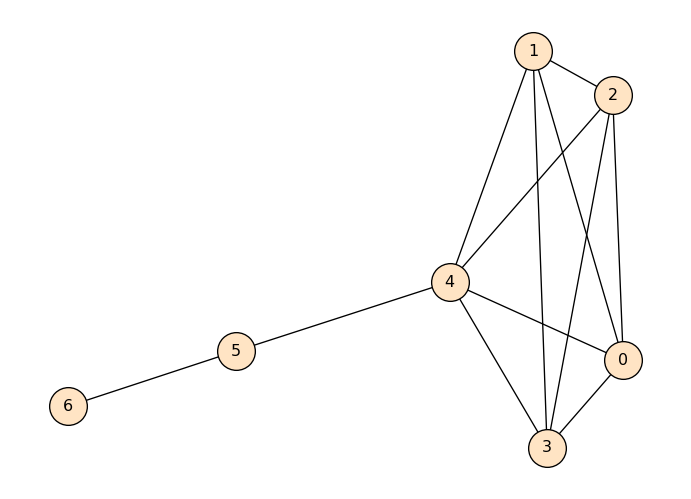

In [5]:
#Create our network
G_cliques_example = nx.Graph()
edges_list = [(0,1),(0,2),(0,3),(0,4),(1,2),(2,3),(3,4),(1,4),(2,4),(1,3),(4,5),(5,6)]
G_cliques_example.add_edges_from(edges_list)
pos = nx.spring_layout(G_cliques_example, seed=1000)

#Find our cliques and print where they are
cliques = [x for x in nx.find_cliques(G_cliques_example)]
print(cliques)

#Draw our graph      
nx.draw(G_cliques_example,pos=pos, with_labels=True, edgecolors="black", node_color = "bisque", node_size=800)

We can see that there are three cliques in this network:
$(4, 0, 1, 2, 3)$, $(4, 5)$, and $(6, 5)$:

[[4, 0, 1, 2, 3], [4, 5], [6, 5]]

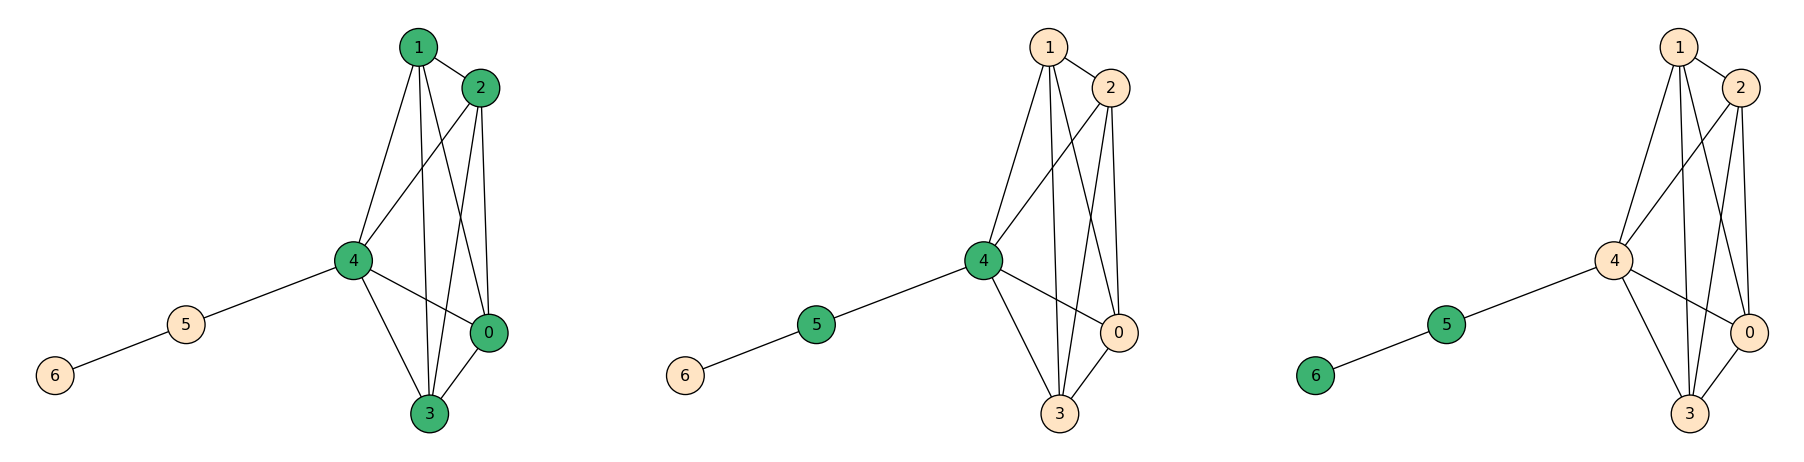

In [6]:
#Set the figure size (24,6) not (8,6) because we have 3 graphs to show
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
fig.set_facecolor('lightblue')

#Create our network
G_cliques_example = nx.Graph()
edges_list = [(0,1),(0,2),(0,3),(0,4),(1,2),(2,3),(3,4),(1,4),(2,4),(1,3),(4,5),(5,6)]
G_cliques_example.add_edges_from(edges_list)
pos = nx.spring_layout(G_cliques_example, seed=1000)

#Find our cliques and print them
cliques = [x for x in nx.find_cliques(G_cliques_example)]
print(cliques)

#Colour our cliques
clique_1 = ["mediumseagreen", "mediumseagreen", "mediumseagreen", "mediumseagreen", "mediumseagreen", "bisque", "bisque"]
clique_2 = ["bisque", "bisque", "bisque",  "bisque", "mediumseagreen", "mediumseagreen", "bisque"]
clique_3 = ["bisque", "bisque", "bisque", "bisque",  "bisque", "mediumseagreen", "mediumseagreen"]

#Draw our cliques       
nx.draw(G_cliques_example, ax=axes[0], pos=pos, with_labels=True, edgecolors="black", node_color = clique_1, node_size=800)
nx.draw(G_cliques_example, ax=axes[1], pos=pos, with_labels=True, edgecolors="black", node_color = clique_2, node_size=800)
nx.draw(G_cliques_example, ax=axes[2], pos=pos, with_labels=True, edgecolors="black", node_color = clique_3, node_size=800)

Here we have them colored green to be easier to see.

[[4, 0, 1, 2, 3], [4, 5], [6, 5]]

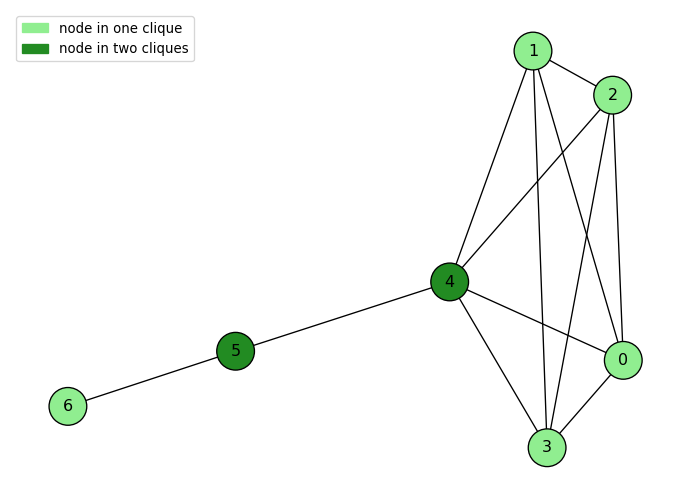

In [7]:
#Create our example graph
G_cliques_example = nx.Graph()
edges_list = [(0,1),(0,2),(0,3),(0,4),(1,2),(2,3),(3,4),(1,4),(2,4),(1,3),(4,5),(5,6)]
G_cliques_example.add_edges_from(edges_list)
pos = nx.spring_layout(G_cliques_example, seed=1000)

#Find the cliques
cliques = [x for x in nx.find_cliques(G_cliques_example)]
print(cliques)

#For loop
node_counts = {}
for clique in cliques: #for each clique in the list of cliques...
    for node in clique: # for each node in each clique...
        if node in node_counts: #checks whether the current node already exists as a key in the node_counts dictionary
            node_counts[node] += 1 #if it is in the dictionary, increase it's value by 1
        else:
            node_counts[node] = 1 #if it isn't, dont change

#Colour our nodes
colors = []
for node in G_cliques_example.nodes():
    if node_counts[node] == 1:
        colors.append("lightgreen")
    elif node_counts[node] == 2:
        colors.append("forestgreen")
    elif node_counts[node] == 3:
        colors.append("orange")
    else:
        colors.append("red")

#Draw our network           
nx.draw(G_cliques_example,pos=pos, with_labels=True, edgecolors="black", node_color = colors, node_size=800)
patch_green = mpatches.Patch(color='lightgreen', label='node in one clique') 
patch_forest = mpatches.Patch(color='forestgreen', label='node in two cliques') 
plt.legend(handles=[patch_green, patch_forest])
plt.show()

## 2.1 Network-level analysis: Clusters and clustering coefficients

A **cluster** (also known as a community) is a set of nodes in a graph
that are densely connected to each other but sparsely connected to nodes
in other clusters. For example, in a social network, a cluster might
represent a group of people who frequently interact with each other but
have fewer interactions with people outside the group. **Community
detection** is the process of finding such communities within nodes.

Before diving into community detection, we first need to understand
modularity. **Modulaity** is a numerical measure for the community
structure of a graph: it compares the density of edges within the
communities of a network to the density of edges between communities. A
positive modularity value suggests a strong community structure, while
values closer to zero or negative indicate that the divisions are no
better than random.

The Louvain algorithm is a community detection method in networks that
aims to optimize modularity. By optimizing modularity, the Louvain
algorithm effectively uncovers natural divisions in the network where
connections are dense within clusters and sparse between them, thus
identifying meaningful community structures.

First, each node is assigned to its own community, and nodes are then
iteratively moved to neighboring communities if it increases the
modularity. In the second phase, the algorithm creates a new network
where each community from the first phase is treated as a single node,
and the process is repeated. This hierarchical approach continues until
no further modularity improvements can be made, resulting in a final set
of communities that maximize modularity.

Let’s first try running the Louvain Algorithm on a random graph to
demonstrate how it works before running it on our real data.

C:\Users\alexr\AppData\Local\Temp\ipykernel_30820\1521976235.py:13: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


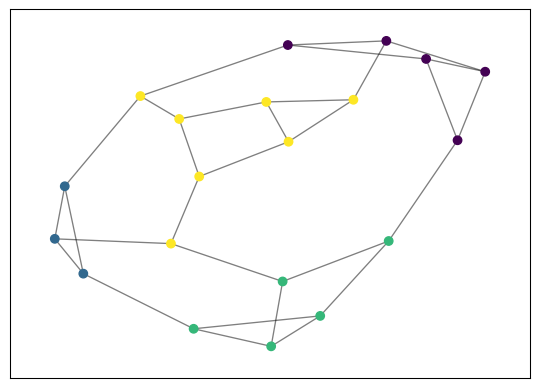

In [8]:
#Set the seed so it is reproducable
random.seed(1)

n = 20  # number of nodes
d = 3   # degree of each node

# Generate the random regular graph
rr_graph = nx.random_regular_graph(d, n)

partition = community_louvain.best_partition(rr_graph)
pos = nx.spring_layout(rr_graph, seed=42)
num_communities = max(partition.values()) + 1
cmap = cm.get_cmap('viridis', num_communities)
nx.draw_networkx_nodes(
    rr_graph, pos, node_size=40, cmap=cmap, node_color=list(partition.values())
)
nx.draw_networkx_edges(rr_graph, pos, alpha=0.5)
plt.show()

We can see by the node coloring that by optimizing modularity the
Louvain Algorithm has found smaller subgroups within our random network.
Now we can try it on our real data.

## 2.2 Louvain Run on Real Data

First lets look at some metrics from the algorithm and a distribution of
community sizes.

Largest connected component nodes: 52992
Running Louvain algorithm...
In our data Louvain has detected 189 communities.

Metrics about Community size:
Average community size: 280.4
Largest community: 1327 people
Smallest community: 19 people

Largest Communities:
Community 33: 1,327 people
Community 83: 1,035 people
Community 52: 1,016 people
Community 128: 926 people
Community 23: 726 people
Community 46: 716 people
Community 12: 675 people
Community 7: 626 people
Community 102: 623 people
Community 9: 595 people

Modularity Score: 0.9603
(Higher modularity indicates stronger community structure)

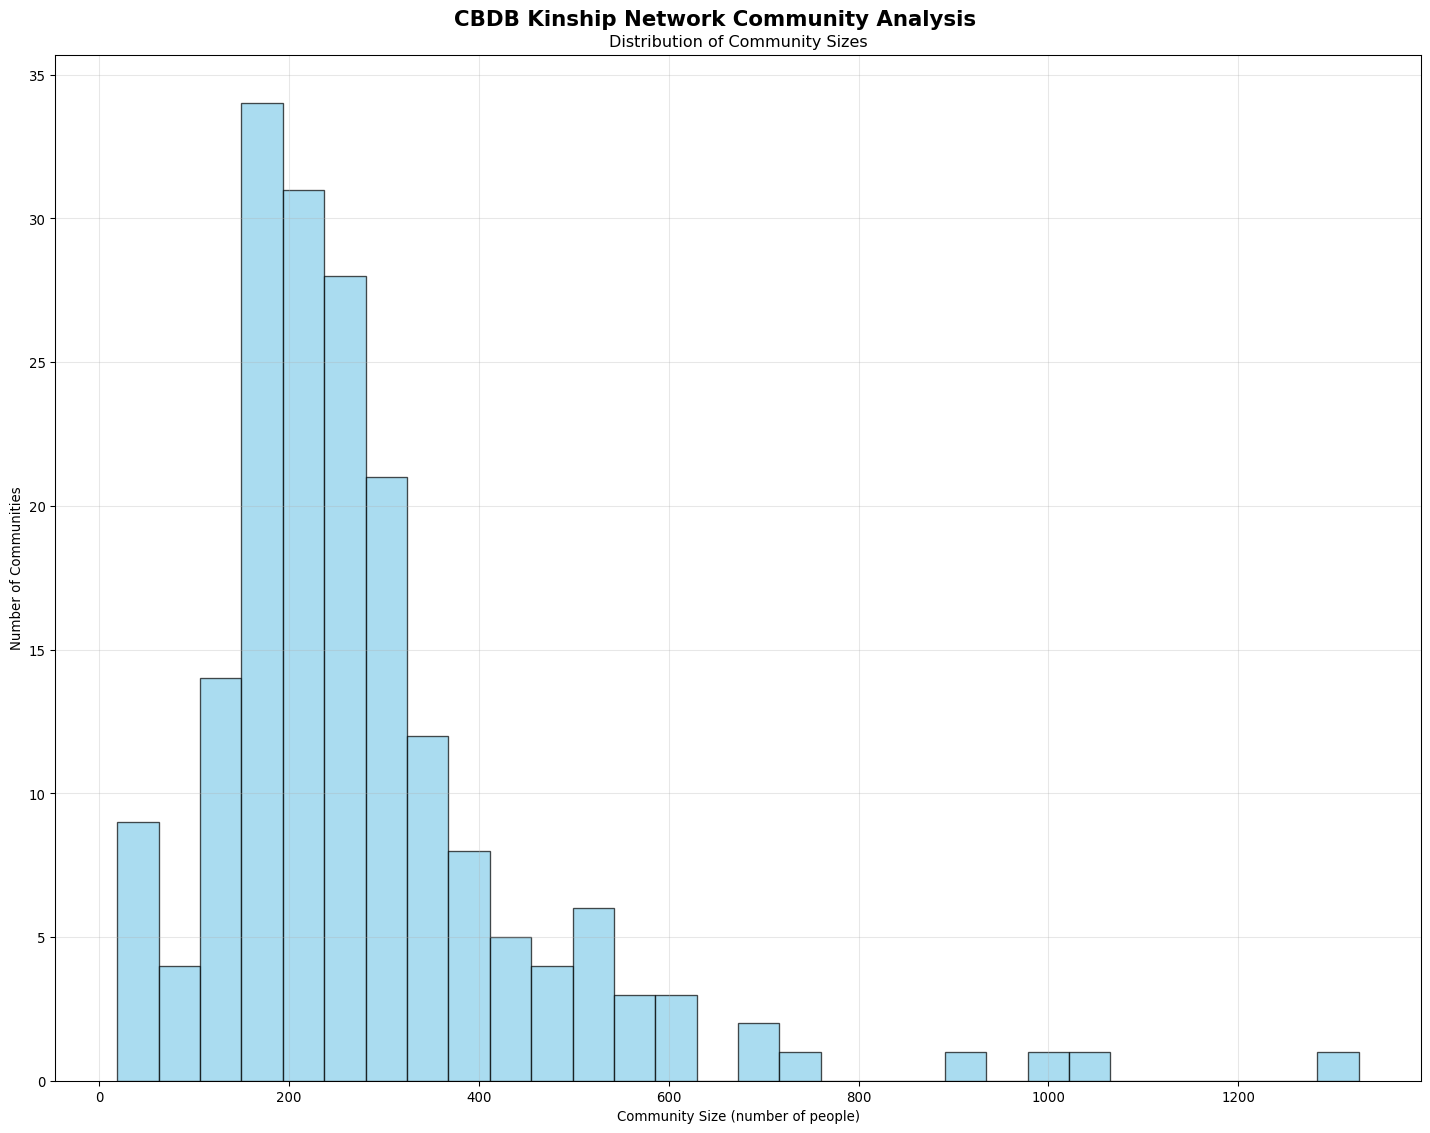

In [9]:
db_path = r'C:\Users\alexr\OneDrive\Desktop\WORK\Summer2025\latest.db'

# Load kinship data into DataFrame
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT c_personid, c_kin_id, c_kin_code FROM KIN_DATA", conn)
conn.close()

# Build the Graph
G = nx.Graph()
for _, row in df.iterrows():
    person = row['c_personid']
    kin = row['c_kin_id']
    kin_type = row['c_kin_code']
    G.add_edge(person, kin, kinship=kin_type)

# Work with the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(largest_cc).copy()
print(f"Largest connected component nodes: {G_sub.number_of_nodes()}")

# Run Louvain Community Detection
print("Running Louvain algorithm...")
partition = community_louvain.best_partition(G_sub)

# Community Analysis Output
num_communities = len(set(partition.values()))
print(f"In our data Louvain has detected {num_communities} communities.")

# Count community sizes
community_sizes = Counter(partition.values())
print(f"\nMetrics about Community size:")
print(f"Average community size: {np.mean(list(community_sizes.values())):.1f}")
print(f"Largest community: {max(community_sizes.values())} people")
print(f"Smallest community: {min(community_sizes.values())} people")

#Show top 10 largest communities
print(f"\nLargest Communities:")
for i, (comm_id, size) in enumerate(community_sizes.most_common(10)):
    print(f"Community {comm_id}: {size:,} people")

# Calculate modularity
modularity = community_louvain.modularity(partition, G_sub)
print(f"\nModularity Score: {modularity:.4f}")
print("(Higher modularity indicates stronger community structure)")

#Distributon Histogram of Community Size
fig, ax = plt.subplots(figsize=(15, 12))
fig.suptitle('CBDB Kinship Network Community Analysis', fontsize=16, fontweight='bold')

# Community size histogram
ax.hist(list(community_sizes.values()), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax.set_xlabel('Community Size (number of people)')
ax.set_ylabel('Number of Communities')
ax.set_title('Distribution of Community Sizes')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

We can see most communities are around 200 - 400 nodes in size.

Lets look at one-two of these smaller community networks in depth and
see how they are structured compared to the KINMATRIX dataset.

The two we will use are:

-   Community 68: 655 people
-   Community 125: 872 people

In [10]:
def visualize_cbdb_community(G_sub, partition, community_id, max_nodes=300):
    # Ensure all node IDs are strings
    community_nodes = [str(node) for node, comm_id in partition.items() if comm_id == community_id]
    
    print(f"Community {community_id}: {len(community_nodes)} people")
    
    # Sample nodes if too large
    if len(community_nodes) > max_nodes:
        print(f"Sampling {max_nodes} nodes for performance...")
        subgraph_full = G_sub.subgraph([int(node) for node in community_nodes])
        degrees = dict(subgraph_full.degree())
        sorted_nodes = sorted(community_nodes, key=lambda x: degrees.get(int(x), 0), reverse=True)
        community_nodes = sorted_nodes[:max_nodes//2] + random.sample(sorted_nodes[max_nodes//2:], max_nodes//2)
    
    # Create subgraph with string node IDs, but degree lookups need int
    subgraph = G_sub.subgraph([int(node) for node in community_nodes])
    print(f"Showing {len(community_nodes)} people, {subgraph.number_of_edges()} relationships")
    
    net = Network(height="700px", width="100%", bgcolor="#ffffff", notebook=True)
    
    for node in community_nodes:
        degree = subgraph.degree[int(node)]  # degree lookup; node as int
        size = max(15, min(35, 15 + degree))
        net.add_node(str(node), 
                     label=str(node), 
                     size=size, 
                     color="#3498db",
                     title=f"Person {node}\nConnections: {degree}")
    
    for u, v, data in subgraph.edges(data=True):
        net.add_edge(str(u), str(v), color="#cccccc", title=f"Kinship: {data.get('kinship','family')}")
    
    filename = f"community_{community_id}.html"
    net.show(filename)
    print(f"Interactive network: {filename}")

# Visualize communities as before
visualize_cbdb_community(G_sub, partition, 68)
visualize_cbdb_community(G_sub, partition, 125)

Community 68: 230 people
Showing 230 people, 246 relationships
community_68.html
Interactive network: community_68.html
Community 125: 224 people
Showing 224 people, 227 relationships
community_125.html
Interactive network: community_125.html

We will again use a PyVis visualization, just like with the KINMATRIX
Visualizations we can zoom and pan around and hover on the nodes. This
time you can also drag the nodes and the surrounding nodes will move
like bacteria under a microscope.

**MORE STUFF**

-   Can add a section on coloring by gender or someother variable of
    interest for these visualizations.

# 3.0 Degree Centrality for Important Family Members

We can see from our community visualization that some members are more
central and connect different parts of the familiy. In family analysis
these would be considered important connectors. In order to examine them
further we will use the measures of centrality we introduced in the
first notebook. Centrality measures are quantitative metrics that
identify the most important or influential nodes within a network, we
will do this to try and identify key historical figures and try to
reveal hidden connections.  
**Note:** The cells below take a very long time to run, so I will leave
it all commented and just have the output pasted below.

In [11]:
#print(f"Analyzing network with {G_sub.number_of_nodes():,} nodes and {G_sub.number_of_edges():,} edges")
#degree_centrality = nx.degree_centrality(G_sub)
#betweenness_centrality = nx.betweenness_centrality(G_sub, k=1000)  
#closeness_centrality = nx.closeness_centrality(G_sub)
#eigenvector_centrality = nx.eigenvector_centrality(G_sub, max_iter=1000)

Create Centrality DataFrame and Display Statistics

In [12]:
#Create a comprehensive centrality dataframe
#centrality_df = pd.DataFrame({
#    'person_id': list(G_sub.nodes()),
#    'degree': [G_sub.degree(node) for node in G_sub.nodes()],
#    'degree_centrality': [degree_centrality[node] for node in G_sub.nodes()],
#    'betweenness_centrality': [betweenness_centrality[node] for node in G_sub.nodes()],
#    'closeness_centrality': [closeness_centrality[node] for node in G_sub.nodes#    'eigenvector_centrality': [eigenvector_centrality[node] for node in G_sub.nodes()]
#})
#print("Centrality Statistics:")
#print(centrality_df.describe())
#print(f"\nDataFrame shape: {centrality_df.shape}")
#print(f"Columns: {list(centrality_df.columns)}")

**Output from above cell** Centrality Statistics: person_id degree
degree_centrality betweenness_centrality  
count 52992.000000 52992.000000 52992.000000 52992.000000  
mean 115894.558952 2.463353 0.000046 0.000341  
std 117167.480510 2.806804 0.000053 0.002023  
min 4.000000 1.000000 0.000019 0.000000  
25% 21419.750000 1.000000 0.000019 0.000000  
50% 119799.500000 2.000000 0.000038 0.000000  
75% 178417.250000 3.000000 0.000057 0.000075  
max 691363.000000 147.000000 0.002774 0.161482

       closeness_centrality  eigenvector_centrality  

count 52992.000000 5.299200e+04  
mean 0.054518 2.787520e-04  
std 0.010117 4.335138e-03  
min 0.024212 1.972009e-17  
25% 0.047437 3.783786e-12  
50% 0.054617 3.964649e-10  
75% 0.061708 4.877353e-08  
max 0.085383 5.227996e-01

Now we can look at the most central nodes in the dataset to try and find
important individuals in the data.

In order to find these key individuals we will use our three centrality
measures.

-   Degree Centrality: These are the family members with the most direct
    kinship ties.
-   Betweeness Centrality: These family members connect different
    branches/generations
-   Eigenvector Centality: These are connected to other highly connected
    family members

In [13]:
#print("Degree Centrality (Most Connected Family Members):")
#top_degree = centrality_df.nlargest(10, 'degree')
#for idx, row in top_degree.iterrows():
#    print(f"Person {row['person_id']:>8}: {row['degree']:>3} connections (centrality: {row['degree_centrality']:.4f})")

#print("Betweeness Centrality (Best Family Bridges):")
#top_betweenness = centrality_df.nlargest(10, 'betweenness_centrality')
#for idx, row in top_betweenness.iterrows():
#    print(f"Person {row['person_id']:>8}: {row['betweenness_centrality']:.4f} (degree: {row['degree']:>3})")

#print("Eigenvector Centality (Most Influential Family Connections):")
#top_eigenvector = centrality_df.nlargest(10, 'eigenvector_centrality')
#for idx, row in top_eigenvector.iterrows():
#    print(f"Person {row['person_id']:>8}: {row['eigenvector_centrality']:.4f} (degree: {row['degree']:>3})")

The cells above has a long run time (30mins so)

Output: **Degree Centrality (Most Connected Family Members):** Person
3211.0: 147.0 connections (centrality: 0.0028) Person 19244.0: 95.0
connections (centrality: 0.0018) Person 9008.0: 80.0 connections
(centrality: 0.0015) Person 9002.0: 69.0 connections (centrality:
0.0013) Person 10502.0: 63.0 connections (centrality: 0.0012) Person
13060.0: 61.0 connections (centrality: 0.0012) Person 3214.0: 56.0
connections (centrality: 0.0011) Person 19246.0: 56.0 connections
(centrality: 0.0011) Person 9001.0: 53.0 connections (centrality:
0.0010) Person 705.0: 52.0 connections (centrality: 0.0010)

**Betweeness Centrality (Best Family Bridges):** Person 13059.0: 0.1588
(degree: 49.0) Person 13626.0: 0.1217 (degree: 14.0) Person 13060.0:
0.1147 (degree: 61.0) Person 8075.0: 0.1137 (degree: 29.0) Person
17267.0: 0.1092 (degree: 4.0) Person 705.0: 0.0717 (degree: 52.0) Person
95047.0: 0.0713 (degree: 10.0) Person 810.0: 0.0685 (degree: 7.0) Person
19244.0: 0.0609 (degree: 95.0) Person 3211.0: 0.0604 (degree: 147.0)

**Eigenvector Centality (Most Influential Family Connections):** Person
3211.0: 0.5228 (degree: 147.0) Person 9002.0: 0.2929 (degree: 69.0)
Person 9001.0: 0.2602 (degree: 53.0) Person 3198.0: 0.2168 (degree:
28.0) Person 10495.0: 0.1676 (degree: 23.0) Person 9003.0: 0.1582
(degree: 35.0) Person 10530.0: 0.1571 (degree: 15.0) Person 10509.0:
0.1546 (degree: 11.0) Person 15975.0: 0.1437 (degree: 11.0) Person
16805.0: 0.1421 (degree: 19.0)

**Analysis**

Lets look at our three types of centrality from before and use them to
order our most important individuals.

-   Degree Centrality: These are the family members with the most direct
    kinship ties.
-   Betweeness Centrality: These family members connect different
    branches/generations
-   Eigenvector Centality: These are connected to other highly connected
    family members

Below are three graphs plotting our output for most central individuals.

<figure>
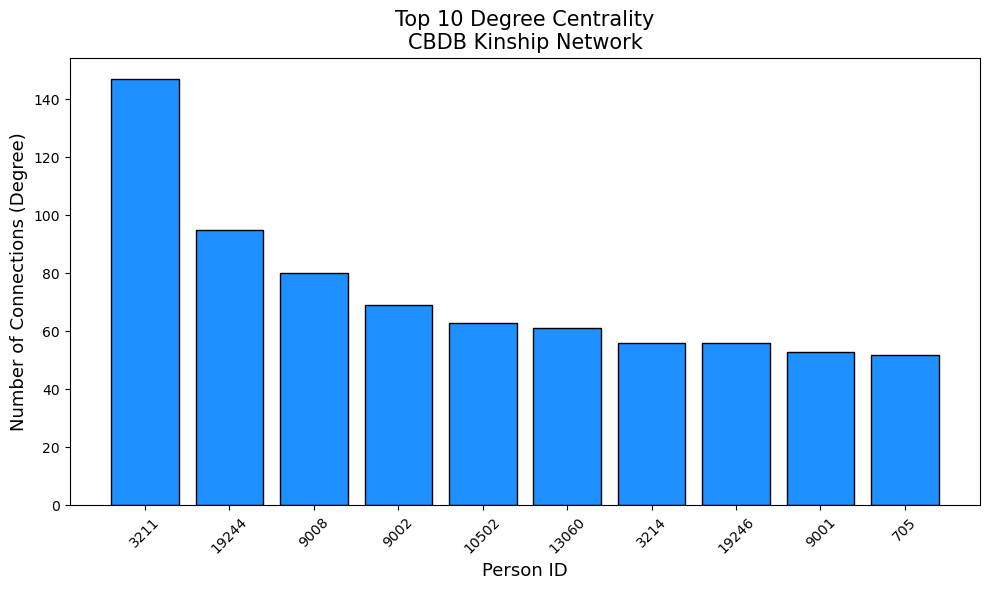
<figcaption aria-hidden="true">Degree Centrality</figcaption>
</figure>

<figure>
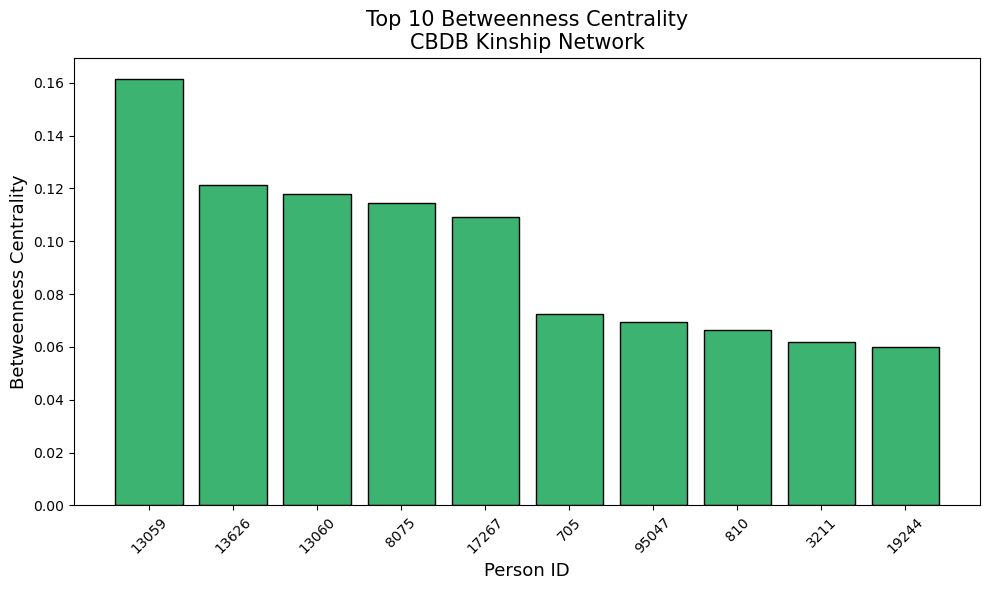
<figcaption aria-hidden="true">Betweenness Centrality</figcaption>
</figure>

<figure>
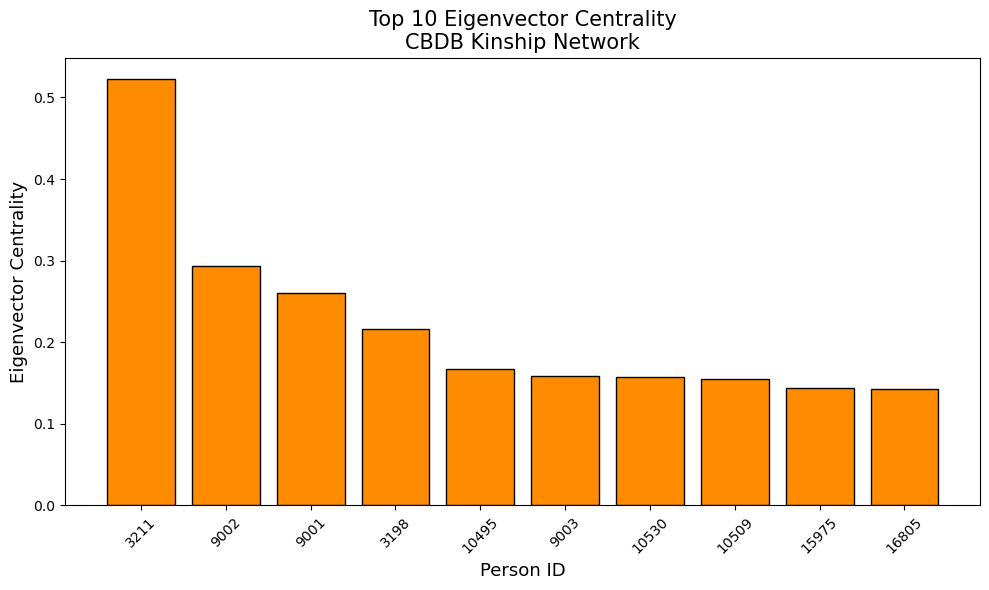
<figcaption aria-hidden="true">Eigenvector Centrality</figcaption>
</figure>

Person 3211 emerges as the most connected individual with 147 kinship
ties, nearly 50% more than the second-most connected person (Person
19244 with 95 connections). This level of connectivity suggests Person
3211 likely represents either a major family patriarch who lived an
exceptionally long life, accumulated multiple marriages and offspring,
or potentially a family line that was consolidated under a single
record. Person 3211 dominates this measure with a score of 0.5228, more
than double the second-highest individual (Person 9002 with 0.2929).
This indicates that Person 3211 is not only highly connected but also
connected to other highly connected families, representing the apex of
elite Chinese society.

Even more striking is Person 17267, who achieves a betweenness
centrality of 0.1092 with only 4 direct connections. This individual
represents what network analysts call a “critical bridge” - someone
whose position in the network gives them disproportionate influence over
information flow and family interactions. In historical Chinese context,
such individuals likely played crucial roles as marriage brokers,
diplomatic intermediaries between family clans, or geographic connectors
linking families across different regions.

# 3.1 Looking at these key individuals

The key people for us to examine further are:

-   Person 3211
-   Person 17267

And our most prominent bridges are below, these nodes have high
betweenness despite lower Degree, meaning they’re crucial “gatekeepers”
between groups.

-   Person 13059
-   Person 13626
-   Person 8075

Let’s find who these people are.

In [14]:
# Connect to DB
conn = sqlite3.connect(db_path)

# Key people from your network analysis
key_people = [3211, 17267, 13059, 13626, 8075]

# Combined query for biography + native place
query = f"""
SELECT 
    bm.c_personid,
    bm.c_name_chn,
    bm.c_surname_chn,
    bm.c_name,
    bm.c_surname,
    bm.c_birthyear,
    bm.c_deathyear,
    bm.c_dy,         -- dynasty code
    bm.c_female,
    a.c_name AS NativePlace_CHN
FROM BIOG_MAIN bm
LEFT JOIN BIOG_ADDR_DATA bad
    ON bm.c_personid = bad.c_personid
    AND bad.c_addr_type = 1
LEFT JOIN ADDRESSES a
    ON bad.c_addr_id = a.c_addr_id
WHERE bm.c_personid IN ({",".join(map(str, key_people))})
"""

# Read into dataframe
df = pd.read_sql_query(query, conn)

# Combine name fields
df["FullName_CHN"] = df["c_surname_chn"].fillna('') + df["c_name_chn"].fillna('')
df["FullName_ENG"] = (df["c_surname"].fillna('') + " " + df["c_name"].fillna('')).str.strip()
df["Gender"] = df["c_female"].map({0: "Male", 1: "Female"})

# Keep relevant columns and remove duplicates
final_df = df[[
    "c_personid", "FullName_CHN", "FullName_ENG",
    "c_birthyear", "c_deathyear", "c_dy", "Gender", "NativePlace_CHN"
]].drop_duplicates()

# Display nicely
display(final_df)

Now we have the information on our most key people. The people with the
highest degree and eigenvector centrality were Zhao Tingmei and Li Zhao.

[Zhao Tingmei](https://en.wikipedia.org/wiki/Zhao_Tingmei) formally
known as Prince Fudao, was an imperial prince of the Song dynasty. On
the wikipedia page it states that he had 15 offsprings so it makes sense
that he is so inter-connected.

The identity of Li Zhao is less clear, but he is most likely [King Li of
Zhou](https://en.wikipedia.org/wiki/King_Li_of_Zhou).

As for our most prominent bridges they are:

-   [Li Fang](https://en.wikipedia.org/wiki/Li_Fang_(Song_dynasty))
-   [Li Yuan(Emperor Gaozu of
    Tang)](https://en.wikipedia.org/wiki/Emperor_Gaozu_of_Tang)
-   Li Yuanyi - I can not find information on him

This is extermenly interesting as we can link all of these nodes to real
people from ancient Chinese history. If we are interested in where they
are from we can also find that using the dataset.

For instance Zhao Tingmei and Li Fang are from Kaifeng. Kaifeng is a
city in central China’s Henan province, just south of the Yellow River.
The city was the Northern Song Dynasty capital from the 10th to 12th
centuries.

Li Yuan(Emperor Gaozu of Tang) and Li Yuanyi are from Chang’an. Chang’an
was a city in China, located near the modern city of Xi’an, which served
as the capital of several Chinese dynasties from 202 BCE to 907 CE.

Finally Li Zhao is from Raoyang, compared to the other two Raoyang is
less historically significant region. Raoyang County is a county in the
southeast of the Hebei province.

# 4.0 Women more as Bridges

This cell explores the BIOG_MAIN table structure to find the gender
field and loads a sample to understand the data structure. In order to
identify women we need the gender information.

In [15]:
def explore_biog_main():
    """Explore BIOG_MAIN table structure to find gender field"""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Explore table structure
    cursor.execute("PRAGMA table_info(BIOG_MAIN)")
    columns = cursor.fetchall()
    print("BIOG_MAIN table columns:")
    for col in columns:
        print(f"  {col[1]} ({col[1]})")
    
    # Test for common gender field names
    gender_fields = ['c_female', 'c_sex', 'c_gender', 'female', 'sex', 'gender']
    gender_field = None
    
    for field in gender_fields:
        try:
            test_query = f"SELECT {field} FROM BIOG_MAIN LIMIT 5"
            cursor.execute(test_query)
            results = cursor.fetchall()
            print(f"\nFound field '{field}' with sample values: {[r[0] for r in results]}")
            gender_field = field
            break
        except:
            continue
        
    conn.close()
    return gender_field

# Run exploration
gender_field = explore_biog_main()

BIOG_MAIN table columns:
  c_personid (c_personid)
  c_name (c_name)
  c_name_chn (c_name_chn)
  c_index_year (c_index_year)
  c_index_year_type_code (c_index_year_type_code)
  c_index_year_source_id (c_index_year_source_id)
  c_female (c_female)
  c_index_addr_id (c_index_addr_id)
  c_index_addr_type_code (c_index_addr_type_code)
  c_ethnicity_code (c_ethnicity_code)
  c_household_status_code (c_household_status_code)
  c_tribe (c_tribe)
  c_birthyear (c_birthyear)
  c_by_nh_code (c_by_nh_code)
  c_by_nh_year (c_by_nh_year)
  c_by_range (c_by_range)
  c_deathyear (c_deathyear)
  c_dy_nh_code (c_dy_nh_code)
  c_dy_nh_year (c_dy_nh_year)
  c_dy_range (c_dy_range)
  c_death_age (c_death_age)
  c_death_age_range (c_death_age_range)
  c_fl_earliest_year (c_fl_earliest_year)
  c_fl_ey_nh_code (c_fl_ey_nh_code)
  c_fl_ey_nh_year (c_fl_ey_nh_year)
  c_fl_ey_notes (c_fl_ey_notes)
  c_fl_latest_year (c_fl_latest_year)
  c_fl_ly_nh_code (c_fl_ly_nh_code)
  c_fl_ly_nh_year (c_fl_ly_nh_year)
  c_f

The variable we are going to use is **c_female,** it is an indicator
variable which takes the values of 0 or 1; where 0 means the node is
female.

We will now load the data from before, but with the gender variable and
rebuild the network.

In [16]:
def load_network_data():
    """Load kinship data and build network efficiently"""
    conn = sqlite3.connect(db_path)
    
    # Load kinship relationships
    kin_df = pd.read_sql_query("SELECT c_personid, c_kin_id, c_kin_code FROM KIN_DATA", conn)
    print(f"Loaded {len(kin_df):,} kinship relationships")
    
    # Build network graph
    G = nx.Graph()
    for _, row in kin_df.iterrows():
        person = row['c_personid']
        kin = row['c_kin_id']
        kin_type = row['c_kin_code']
        G.add_edge(person, kin, kinship=kin_type)
    
    print(f"Full network: {G.number_of_nodes():,} nodes, {G.number_of_edges():,} edges")
    
    # Work with largest connected component for computational efficiency
    largest_cc = max(nx.connected_components(G), key=len)
    G_sub = G.subgraph(largest_cc).copy()
    print(f"Largest component: {G_sub.number_of_nodes():,} nodes, {G_sub.number_of_edges():,} edges")
    
    conn.close()
    return G_sub, kin_df

# Load the network
G_sub, kin_df = load_network_data()

Loaded 543,846 kinship relationships
Full network: 278,262 nodes, 272,717 edges
Largest component: 52,992 nodes, 65,269 edges

Find betweeneness Centrality from previous **Might have to change**

We will find the betweenness, closeness and eigenvector centrality from
before, because of the long computations times this cell will also be
commented out and the output printed below.

In [17]:
#def create_centrality_dataframe(G_sub, degree_centrality, betweenness_centrality, 
#                               closeness_centrality, eigenvector_centrality):

    # Create comprehensive centrality dataframe using your existing variables
#    analysis_df = pd.DataFrame({
#        'person_id': list(G_sub.nodes()),
#        'degree': [G_sub.degree(node) for node in G_sub.nodes()],
#        'degree_centrality': [degree_centrality[node] for node in G_sub.nodes()],
#        'betweenness_centrality': [betweenness_centrality[node] for node in G_sub.nodes()],
#        'closeness_centrality': [closeness_centrality[node] for node in G_sub.nodes()],
#       'eigenvector_centrality': [eigenvector_centrality[node] for node in G_sub.nodes()]
#    })
    
#    print(f"Centrality analysis complete for {len(analysis_df):,} individuals")
#    print(f"Average degree: {analysis_df['degree'].mean():.2f}")
#    print(f"Average betweenness centrality: {analysis_df['betweenness_centrality'].mean():.6f}")
#    print(f"Average closeness centrality: {analysis_df['closeness_centrality'].mean():.6f}")
#    print(f"Average eigenvector centrality: {analysis_df['eigenvector_centrality'].mean():.6f}")
    
#    return analysis_df

# Use your existing centrality calculations (no recalculation needed!)
#centrality_df = create_centrality_dataframe(G_sub, degree_centrality, betweenness_centrality, closeness_centrality, eigenvector_centrality)

Centrality analysis complete for 52,992 individuals Average degree: 2.46
Average betweenness centrality: 0.000342 Average closeness centrality:
0.054518 Average eigenvector centrality: 0.000279

Load Gender and add Gender variable:

-   Gender field = c_female (BOOLEAN(2))
-   Birth year field = c_birthyear
-   Death year field = c_deathyear
-   Index year field = c_index_year

We still need centrality so this cell will also be commented out: **Also
an issue in this cell thats why the {} is there do not get rid of it for
now**

In [18]:
#}#def load_and_merge_gender_data(centrality_df, gender_field='c_female'):
#    """Load gender & year data from BIOG_MAIN and merge with centrality_df"""
#    conn = sqlite3.connect(db_path)

#    biog_query = f"""
#        SELECT 
#            c_personid, 
#            c_name_chn, 
#            c_name,
#            {gender_field} AS gender,
#            c_birthyear,
#            c_deathyear,
#            c_index_year
#        FROM BIOG_MAIN
#        WHERE {gender_field} IS NOT NULL
#    """
#    biog_df = pd.read_sql_query(biog_query, conn)
#    conn.close()
#    print(f"Loaded {len(biog_df):,} individuals with gender info")
#    merged_df = centrality_df.merge(
#        biog_df[['c_personid', 'gender', 'c_birthyear', 'c_deathyear', 'c_index_year']],
#        left_on='person_id',
#        right_on='c_personid',
#        how='left'
#    )
    # Gender distribution
#    print("\nGender distribution (0=male, 1=female):")
#    print(merged_df['gender'].value_counts(dropna=False))

#    coverage = merged_df['gender'].notna().sum() / len(merged_df) * 100
#    print(f"Gender data coverage: {coverage:.1f}% of network nodes")

#    return merged_df

#final_df = load_and_merge_gender_data(centrality_df, gender_field='c_female')

**Output:** Gender distribution (0=male, 1=female): gender 0 48869 1
4123 Name: count, dtype: int64 Gender data coverage: 100.0% of network
nodes

We can see from the output that the majority of nodes are male which
makes sense as for historical records they are more likely to record
men. Only 7.8% of the nodes are female.

In [19]:
#final_df['gender_label'] = final_df['gender'].map({0: 'Male', 1: 'Female'})
#bridge_thresh = 0.001 #Define a 'bridge' threshold

#female_bridges = final_df[(final_df['gender_label'] == 'Female') & 
#                          (final_df['betweenness_centrality'] > bridge_thresh)]
#male_bridges = final_df[(final_df['gender_label'] == 'Male') & 
#                        (final_df['betweenness_centrality'] > bridge_thresh)]

#n_female = (final_df['gender_label'] == 'Female').sum()
#n_male = (final_df['gender_label'] == 'Male').sum()

#prop_female_bridges = len(female_bridges) / n_female * 100 if n_female else 0
#prop_male_bridges = len(male_bridges) / n_male * 100 if n_male else 0

#print(f"Females with betweenness > {bridge_thresh}: {len(female_bridges)} / {n_female} ({prop_female_bridges:.2f}%)")
#print(f"Males with betweenness > {bridge_thresh}: {len(male_bridges)} / {n_male} ({prop_male_bridges:.2f}%)")

Females with betweenness \> 0.001: 101 / 4123 (2.45%) Males with
betweenness \> 0.001: 4452 / 48869 (9.11%)

We can see that 9.11% percent of men pass our treshold of 0.001 while
only 2.45% of women, so most of the main ‘bridges’ in our dataset are
men.

In [20]:
#final_df['gender_label'] = final_df['gender'].map({0: 'Male', 1: 'Female'})

#bridge_thresh = 0.01 # Define a 'bridge' threshold 

#female_bridges = final_df[(final_df['gender_label'] == 'Female') & 
#                          (final_df['betweenness_centrality'] > bridge_thresh)]
#male_bridges = final_df[(final_df['gender_label'] == 'Male') & 
#                        (final_df['betweenness_centrality'] > bridge_thresh)]

#n_female = (final_df['gender_label'] == 'Female').sum()
#n_male = (final_df['gender_label'] == 'Male').sum()

#prop_female_bridges = len(female_bridges) / n_female * 100 if n_female else 0
#prop_male_bridges = len(male_bridges) / n_male * 100 if n_male else 0

#print(f"Females with betweenness > {bridge_thresh}: {len(female_bridges)} / {n_female} ({prop_female_bridges:.2f}%)")
#print(f"Males with betweenness > {bridge_thresh}: {len(male_bridges)} / {n_male} ({prop_male_bridges:.2f}%)")

Output: Females with betweenness \> 0.01: 5 / 4123 (0.12%) Males with
betweenness \> 0.01: 205 / 48869 (0.42%)

If we up our treshhold we can see that this does not change with 0.42%
men compared to 0.12% women passing our treshhold of 0.01.

Find best female connections

In [21]:
#top_female_bridges = final_df[final_df['gender_label'] == 'Female'].nlargest(10, 'betweenness_centrality')
#print("Top 10 Female Bridges in the Network:")
#for i, row in top_female_bridges.iterrows():
#    print(f"Person {row['person_id']}: Betweenness={row['betweenness_centrality']:.3f}, Degree={row['degree']}")

Top 10 Female Bridges in the Network: Person 141303: Betweenness=0.037,
Degree=12 Person 93663: Betweenness=0.029, Degree=28 Person 17702:
Betweenness=0.015, Degree=11 Person 142641: Betweenness=0.011, Degree=6
Person 140204: Betweenness=0.010, Degree=5 Person 4217:
Betweenness=0.009, Degree=12 Person 141789: Betweenness=0.009, Degree=12
Person 194260: Betweenness=0.009, Degree=8 Person 134070:
Betweenness=0.009, Degree=3 Person 141996: Betweenness=0.008, Degree=15

As with the best male connectors let’s find the identies of the top 3
female bridges:

-   Person 141303: Betweenness=0.037, Degree=12
-   Person 93663: Betweenness=0.029, Degree=28
-   Person 17702: Betweenness=0.015, Degree=11

In [22]:
conn = sqlite3.connect(db_path)

# Key people from your network analysis
key_women = [141303, 93663, 17702]

# Combined query for biography + native place
query = f"""
SELECT 
    bm.c_personid,
    bm.c_name_chn,
    bm.c_surname_chn,
    bm.c_name,
    bm.c_surname,
    bm.c_birthyear,
    bm.c_deathyear,
    bm.c_dy,         -- dynasty code
    bm.c_female,
    a.c_name AS NativePlace_CHN
FROM BIOG_MAIN bm
LEFT JOIN BIOG_ADDR_DATA bad
    ON bm.c_personid = bad.c_personid
    AND bad.c_addr_type = 1
LEFT JOIN ADDRESSES a
    ON bad.c_addr_id = a.c_addr_id
WHERE bm.c_personid IN ({",".join(map(str, key_women))})
"""

# Read into dataframe
df = pd.read_sql_query(query, conn)

# Combine name fields
df["FullName_CHN"] = df["c_surname_chn"].fillna('') + df["c_name_chn"].fillna('')
df["FullName_ENG"] = (df["c_surname"].fillna('') + " " + df["c_name"].fillna('')).str.strip()
df["Gender"] = df["c_female"].map({0: "Male", 1: "Female"})

# Keep relevant columns and remove duplicates
final_df = df[[
    "c_personid", "FullName_CHN", "FullName_ENG",
    "c_birthyear", "c_deathyear", "c_dy", "Gender", "NativePlace_CHN"
]].drop_duplicates()

# Display nicely
display(final_df)

The top women ‘bridges’ in our dataset are:

-   Wu Shi is the wife of [Emperor Gaozong of
    Song](https://en.wikipedia.org/wiki/Emperor_Gaozong_of_Song).
-   [Wu Zhao(Wu Zetian)](https://en.wikipedia.org/wiki/Wu_Zetian)was
    empress of China from 660 to 705, ruling first through others and
    later in her own right. She ruled as empress through her husband
    Emperor Gaozong and later as empress dowager through her sons
    Emperors Zhongzong and Ruizong, from 660 to 690
-   Cui Sui is most likely daugher of [Cui Ting
    Shi](https://en.wikipedia.org/wiki/Cui_Shi).

# 5.0 Networks over time Cross-Dynasty First, then Set Time Periods

Next we will look at the dynasties over time and try to determine if
there are quantifiable differences between the networks for each of
these dynasties.

To determine the dynasty we will use the c_index_year variable and if
that does not exist as a substitute we will use c_birthyear

**NOTE:MAYBE USE BUILT IN DYNASTY VARIABLES NEXT ATTEMPT**

Load more data and define dynasties.

In [23]:
conn = sqlite3.connect(db_path)
biog_df = pd.read_sql_query("""
    SELECT c_personid, c_birthyear, c_deathyear, c_index_year
    FROM BIOG_MAIN""", conn)

def assign_dynasty(row):
    year = row['c_index_year']
    if year is None:
        year = row['c_birthyear'] 
    if year is None:
        return 'Unknown'
    if 0 <= year <= 618: return 'Pre-Tang'
    if 618 <= year <= 907: return 'Tang'
    if 907 < year < 960: return 'Five Dynasties/10 Kingdoms'
    if 960 <= year <= 1279: return 'Song'
    if 1279 <= year <= 1368: return 'Yuan'
    if 1368 <= year <= 1644: return 'Ming'
    if 1644 <= year <= 1912: return 'Qing'
    if 1912 <= year <= 2025: return 'Modern'
    return 'Other'

biog_df['dynasty'] = biog_df.apply(assign_dynasty, axis=1)
conn.close()

print(biog_df['dynasty'].value_counts())

dynasty
Other                         347684
Ming                          133391
Qing                           60768
Song                           52995
Tang                           37246
Pre-Tang                        8692
Yuan                            6000
Five Dynasties/10 Kingdoms      2691
Modern                            66
Name: count, dtype: int64

Filter by dynasties

In [24]:
# Load kinship relationships
conn = sqlite3.connect(db_path)
kin_df = pd.read_sql_query("SELECT c_personid, c_kin_id FROM KIN_DATA", conn)
conn.close()

# Merge dynasty info for person and kin
kin_df = kin_df.merge(biog_df[['c_personid', 'dynasty']],
                      left_on='c_personid', right_on='c_personid', how='left')
kin_df = kin_df.merge(biog_df[['c_personid', 'dynasty']],
                      left_on='c_kin_id', right_on='c_personid', how='left',
                      suffixes=('_person', '_kin'))

print(kin_df.columns)

# Function to build per-dynasty graphs
def build_dynasty_networks(kin_df):
    dynasty_graphs = {}
    for dyn in kin_df['dynasty_person'].dropna().unique():
        sub_edges = kin_df[kin_df['dynasty_person'] == dyn]
        G = nx.Graph()
        # Use new column names after merge
        G.add_edges_from(zip(sub_edges['c_personid_person'], sub_edges['c_kin_id']))
        dynasty_graphs[dyn] = G
        print(f"Dynasty {dyn}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return dynasty_graphs

dynasty_graphs = build_dynasty_networks(kin_df)

Index(['c_personid_person', 'c_kin_id', 'dynasty_person', 'c_personid_kin',
       'dynasty_kin'],
      dtype='object')
Dynasty Other: 95971 nodes, 71525 edges
Dynasty Song: 36880 nodes, 43952 edges
Dynasty Five Dynasties/10 Kingdoms: 5668 nodes, 5454 edges
Dynasty Tang: 45875 nodes, 45684 edges
Dynasty Pre-Tang: 13662 nodes, 12375 edges
Dynasty Yuan: 5733 nodes, 5264 edges
Dynasty Ming: 150844 nodes, 139453 edges
Dynasty Qing: 21093 nodes, 18648 edges
Dynasty Modern: 81 nodes, 60 edges

Dynasty Other: 95971 nodes, 71525 edges Dynasty Song: 36837 nodes, 43886
edges Dynasty Tang: 50102 nodes, 50263 edges Dynasty Pre-Tang: 13662
nodes, 12375 edges Dynasty Yuan: 5733 nodes, 5264 edges Dynasty Ming:
150844 nodes, 139453 edges Dynasty Qing: 21093 nodes, 18648 edges
Dynasty Modern: 81 nodes, 60 edges

There is very little modern as the scope of the dataset is from the 7th
through the 19th century so this makes sense.

We can ignore other, and modern for this analysis.

Now we will calculate Degree Centrality, Density, Clustering
Coefficient, Modularity for our dynasties.

In [25]:
# List of included dynasties
included_dynasties = ['Song', 'Tang', 'Pre-Tang', 'Yuan', 'Ming', 'Qing']

def analyze_dynasty_metrics_selected(dynasty_graphs, included_dynasties):
    results = {}
    for dyn_name in included_dynasties:
        G = dynasty_graphs.get(dyn_name)
        if G is None:
            continue
        # Degree centrality
        deg_cent = nx.degree_centrality(G)
        avg_deg_cent = sum(deg_cent.values()) / len(deg_cent)

        # Average degree per node (raw, not normalized)
        avg_degree = (2 * G.number_of_edges()) / G.number_of_nodes()

        # Graph density
        density = nx.density(G)

        # Clustering coefficient (average)
        avg_clust = nx.average_clustering(G)

        # Community detection: modularity
        communities = list(nx.community.greedy_modularity_communities(G))
        modularity = nx.community.modularity(G, communities)

        results[dyn_name] = {
            "avg_degree_centrality": avg_deg_cent,
            "avg_degree": avg_degree,
            "density": density,
            "avg_clustering_coefficient": avg_clust,
            "modularity": modularity
        }
        print(f"{dyn_name}: Avg Degree Centrality={avg_deg_cent:.4f}, Avg Degree={avg_degree:.2f}, "
              f"Density={density:.6f}, Avg Clust Coeff={avg_clust:.4f}, Modularity={modularity:.4f}")
    return results

# Example usage
dynasty_metrics_selected = analyze_dynasty_metrics_selected(dynasty_graphs, included_dynasties)

Song: Avg Degree Centrality=0.0001, Avg Degree=2.38, Density=0.000065, Avg Clust Coeff=0.1852, Modularity=0.9634
Tang: Avg Degree Centrality=0.0000, Avg Degree=1.99, Density=0.000043, Avg Clust Coeff=0.0708, Modularity=0.9905
Pre-Tang: Avg Degree Centrality=0.0001, Avg Degree=1.81, Density=0.000133, Avg Clust Coeff=0.0291, Modularity=0.9889
Yuan: Avg Degree Centrality=0.0003, Avg Degree=1.84, Density=0.000320, Avg Clust Coeff=0.0936, Modularity=0.9929
Ming: Avg Degree Centrality=0.0000, Avg Degree=1.85, Density=0.000012, Avg Clust Coeff=0.0207, Modularity=0.9999
Qing: Avg Degree Centrality=0.0001, Avg Degree=1.77, Density=0.000084, Avg Clust Coeff=0.0753, Modularity=0.9983

**Output:** Song: Avg Degree Centrality=0.0001, Avg Degree=2.38,
Density=0.000065, Avg Clust Coeff=0.1852, Modularity=0.9634 Tang: Avg
Degree Centrality=0.0000, Avg Degree=1.99, Density=0.000043, Avg Clust
Coeff=0.0708, Modularity=0.9905 Pre-Tang: Avg Degree Centrality=0.0001,
Avg Degree=1.81, Density=0.000133, Avg Clust Coeff=0.0291,
Modularity=0.9889 Yuan: Avg Degree Centrality=0.0003, Avg Degree=1.84,
Density=0.000320, Avg Clust Coeff=0.0936, Modularity=0.9929 Ming: Avg
Degree Centrality=0.0000, Avg Degree=1.85, Density=0.000012, Avg Clust
Coeff=0.0207, Modularity=0.9999 Qing: Avg Degree Centrality=0.0001, Avg
Degree=1.77, Density=0.000084, Avg Clust Coeff=0.0753, Modularity=0.9983

From findings we will see that Degree Centrality and Density are very
small these are expected because of the huge size of the network. We
also have very high modularity near 1, as expected in a family network
there are strong community structures. Let’s continue with our analysis.

Degree Distribution Shape Analysis

Song: Mean=2.38 Std=2.70, Skewness=7.35
Tang: Mean=1.99 Std=2.14, Skewness=6.28
Pre-Tang: Mean=1.81 Std=1.61, Skewness=8.27
Yuan: Mean=1.84 Std=2.49, Skewness=8.62
Ming: Mean=1.85 Std=2.72, Skewness=3.91
Qing: Mean=1.77 Std=2.26, Skewness=9.24

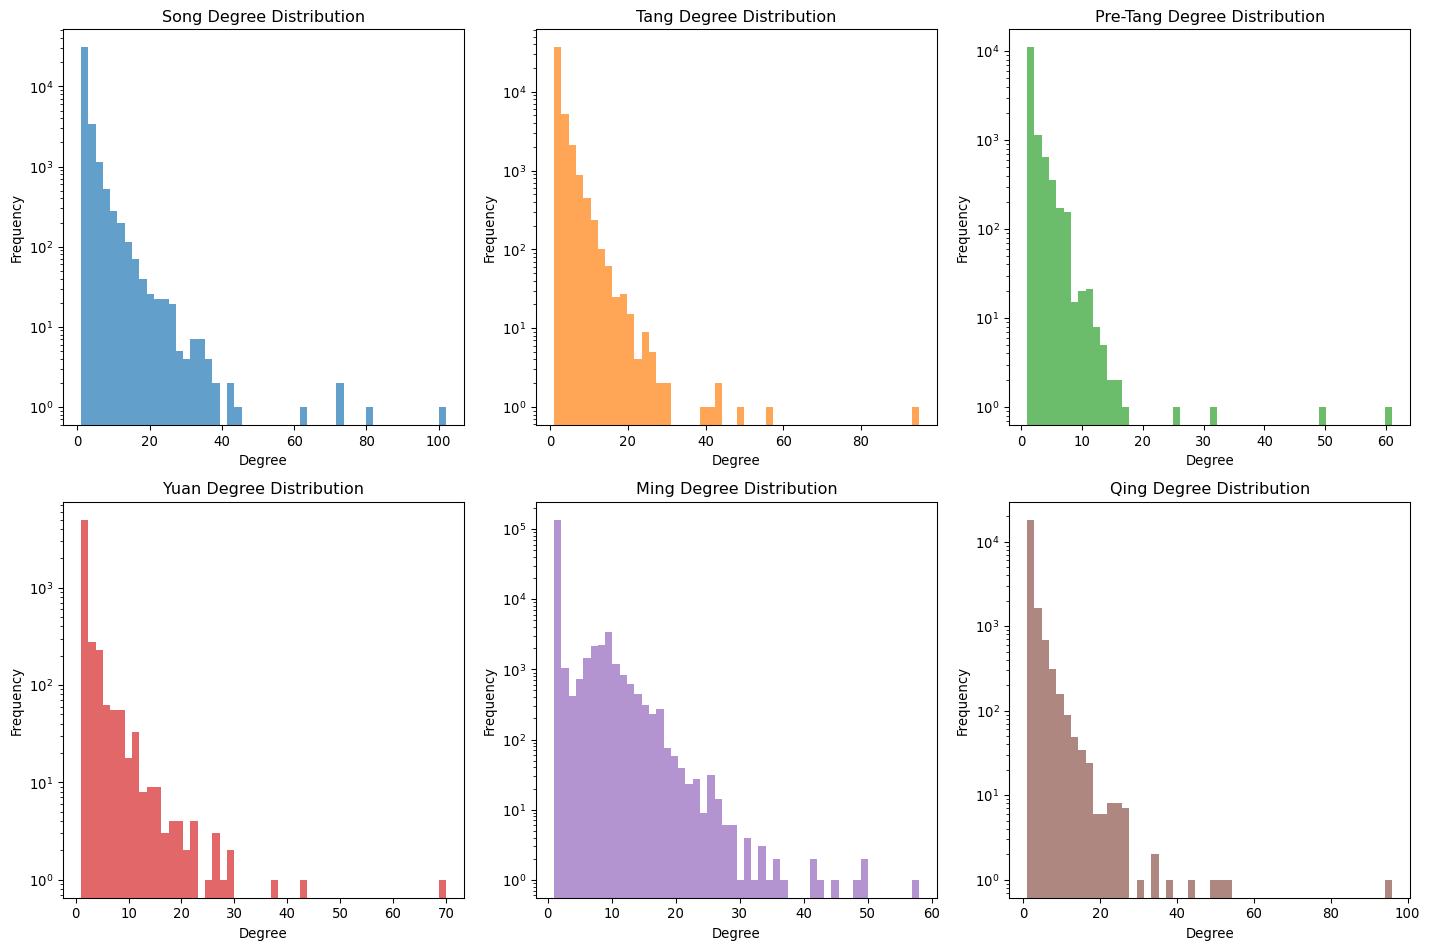

In [26]:
def analyze_degree_distributions(dynasty_graphs, included_dynasties):
    plt.figure(figsize=(15, 10))
    
    for i, dyn_name in enumerate(included_dynasties):
        G = dynasty_graphs.get(dyn_name)
        if G is None:
            continue
            
        degrees = [d for n, d in G.degree()]
        
        # Plot distribution
        plt.subplot(2, 3, i+1)
        plt.hist(degrees, bins=50, alpha=0.7, color=f'C{i}')
        plt.title(f'{dyn_name} Degree Distribution')
        plt.xlabel('Degree')
        plt.ylabel('Frequency')
        plt.yscale('log')  # Log scale to see heavy tails
        
        # Calculate distribution statistics
        mean_deg = np.mean(degrees)
        median_deg = np.median(degrees)
        max_deg = max(degrees)
        std_deg = np.std(degrees)
        skewness = stats.skew(degrees)
        
        print(f"{dyn_name}: Mean={mean_deg:.2f} "
              f"Std={std_deg:.2f}, Skewness={skewness:.2f}")
    
    plt.tight_layout()
    plt.show()

# Run analysis
analyze_degree_distributions(dynasty_graphs, included_dynasties)

**Output:**

-   Song: Mean=2.38 Std=2.70, Skewness=7.35
-   Tang: Mean=1.99 Std=2.14, Skewness=6.28
-   Pre-Tang: Mean=1.81 Std=1.61, Skewness=8.27
-   Yuan: Mean=1.84 Std=2.49, Skewness=8.62
-   Ming: Mean=1.85 Std=2.72, Skewness=3.91
-   Qing: Mean=1.77 Std=2.26, Skewness=9.24

Our visualization is a histogram of the frequency of high degree nodes.
All of them are similar except for the Ming Dynasty.

**ADD WHY**

We will continue our analysis with looking at how many components each
dynasty has and their fragmentation and average size.

Connected Components Analysis

In [27]:
def analyze_connected_components(dynasty_graphs, included_dynasties):
    results = {}
    
    for dyn_name in included_dynasties:
        G = dynasty_graphs.get(dyn_name)
        if G is None:
            continue
            
        # Get connected components
        components = list(nx.connected_components(G))
        num_components = len(components)
        component_sizes = [len(c) for c in components]
        
        # Calculate metrics
        largest_component_size = max(component_sizes) if component_sizes else 0
        fragmentation_index = 1 - (largest_component_size / G.number_of_nodes())
        avg_component_size = np.mean(component_sizes) if component_sizes else 0
        
        results[dyn_name] = {
            "num_components": num_components,
            "largest_component_size": largest_component_size,
            "fragmentation_index": fragmentation_index,
            "avg_component_size": avg_component_size,
            "component_sizes": component_sizes
        }
        
        print(f"{dyn_name}: Components={num_components}, "
              f"Largest={largest_component_size}, "
              f"Fragmentation={fragmentation_index:.4f}, "
              f"Avg Size={avg_component_size:.2f}")
    
    return results

# Run analysis
component_results = analyze_connected_components(dynasty_graphs, included_dynasties)

Song: Components=2606, Largest=22388, Fragmentation=0.3930, Avg Size=14.15
Tang: Components=4523, Largest=14589, Fragmentation=0.6820, Avg Size=10.14
Pre-Tang: Components=1862, Largest=3643, Fragmentation=0.7333, Avg Size=7.34
Yuan: Components=1191, Largest=277, Fragmentation=0.9517, Avg Size=4.81
Ming: Components=15051, Largest=273, Fragmentation=0.9982, Avg Size=10.02
Qing: Components=4340, Largest=343, Fragmentation=0.9837, Avg Size=4.86

**Output:** Song: Components=2607, Largest=22359, Fragmentation=0.3930,
Avg Size=14.13 Tang: Components=4790, Largest=16733,
Fragmentation=0.6660, Avg Size=10.46 Pre-Tang: Components=1862,
Largest=3643, Fragmentation=0.7333, Avg Size=7.34 Yuan: Components=1191,
Largest=277, Fragmentation=0.9517, Avg Size=4.81 Ming: Components=15051,
Largest=273, Fragmentation=0.9982, Avg Size=10.02 Qing: Components=4340,
Largest=343, Fragmentation=0.9837, Avg Size=4.86

As expected the Pre-Tang dynasty is quite disconnected with many smaller
clusters. The Song dynasty has the lowest fragmentation and the largest
component meaning most of the network for this dynasty is one large
component. The Yuan dynasty is also very fragmented which is suprising
as it covered a large political period. The Ming dynasty has the most
components by far but a minuscule largest connected cluster

We will contunue with temporal patterning analysis to see if within
these dynasties there were large changes throughout the years.

We will use the ‘c_index_year’ variable to see if density, clustering,
or avg degree changes over time inside a dynasty.

In [28]:
def analyze_temporal_patterns(kin_df, biog_df, included_dynasties):
    # Merge to get year information for each edge
    kin_temporal = kin_df.merge(biog_df[['c_personid', 'c_index_year', 'dynasty']], 
                               left_on='c_personid_person', right_on='c_personid', how='left')
    
    results = {}
    
    for dyn_name in included_dynasties:
        dyn_data = kin_temporal[kin_temporal['dynasty_person'] == dyn_name].copy()
        
        # Group by time periods (e.g., 50-year bins)
        if dyn_data['c_index_year'].notna().sum() > 0:
            min_year = int(dyn_data['c_index_year'].min())
            max_year = int(dyn_data['c_index_year'].max())
            
            # Create 50-year bins
            bins = range(min_year, max_year + 50, 50)
            dyn_data['time_bin'] = pd.cut(dyn_data['c_index_year'], bins=bins)
            
            # Calculate metrics per time period
            temporal_metrics = []
            for time_bin in dyn_data['time_bin'].cat.categories:
                bin_data = dyn_data[dyn_data['time_bin'] == time_bin]
                if len(bin_data) > 10:  # Only analyze bins with sufficient data
                    # Create subgraph for this time period
                    edges = zip(bin_data['c_personid_person'], bin_data['c_kin_id'])
                    temp_G = nx.Graph()
                    temp_G.add_edges_from(edges)
                    
                    if temp_G.number_of_nodes() > 0:
                        avg_deg = (2 * temp_G.number_of_edges()) / temp_G.number_of_nodes()
                        density = nx.density(temp_G)
                        clustering = nx.average_clustering(temp_G)
                        
                        temporal_metrics.append({
                            'time_period': str(time_bin),
                            'avg_degree': avg_deg,
                            'density': density,
                            'clustering': clustering,
                            'nodes': temp_G.number_of_nodes(),
                            'edges': temp_G.number_of_edges()
                        })
            
            results[dyn_name] = temporal_metrics
            
            # Print summary
            print(f"\n{dyn_name} Temporal Analysis ({min_year}-{max_year}):")
            for metric in temporal_metrics[:5]:  # Show first 5 time periods
                print(f"  {metric['time_period']}: Avg Degree={metric['avg_degree']:.2f}, "
                      f"Density={metric['density']:.6f}, Clustering={metric['clustering']:.4f}")
    
    return results

# Run temporal analysis
temporal_results = analyze_temporal_patterns(kin_df, biog_df, included_dynasties)


Song Temporal Analysis (960-1279):
  (960, 1010]: Avg Degree=2.08, Density=0.000247, Clustering=0.0856
  (1010, 1060]: Avg Degree=2.04, Density=0.000175, Clustering=0.1023
  (1060, 1110]: Avg Degree=1.93, Density=0.000154, Clustering=0.0986
  (1110, 1160]: Avg Degree=1.98, Density=0.000160, Clustering=0.1434
  (1160, 1210]: Avg Degree=1.97, Density=0.000206, Clustering=0.2235

Tang Temporal Analysis (619-907):
  (619, 669]: Avg Degree=1.66, Density=0.000108, Clustering=0.0210
  (669, 719]: Avg Degree=1.68, Density=0.000096, Clustering=0.0282
  (719, 769]: Avg Degree=1.79, Density=0.000100, Clustering=0.0572
  (769, 819]: Avg Degree=1.84, Density=0.000116, Clustering=0.0667
  (819, 869]: Avg Degree=1.67, Density=0.000244, Clustering=0.0362

Pre-Tang Temporal Analysis (0-618):
  (0, 50]: Avg Degree=1.60, Density=0.012476, Clustering=0.0362
  (50, 100]: Avg Degree=1.69, Density=0.013769, Clustering=0.0447
  (100, 150]: Avg Degree=1.46, Density=0.036585, Clustering=0.0569
  (150, 200]: Av

Dynasty findings point form for now:

-   Song: Late Song becomes more clustered and somewhat denser compared
    to early Song.
-   Tang: The average degre is quite stable with a slight spike in the
    middle. Clustering gradually increases from very low (0.0210) to
    peak at mid-period (0.0667), then drops similar to average degree.
-   Pre-Tang: The clustering increases through the years which makes
    sense.
-   Yuan: Large drop in average degree (1.94 to 1.59) and large decrease
    in clustering (0.1219 to 0.0221)
-   Ming: Very stable compared to other dynasties
-   Qing: Early Qing is more cohesive than late Qing except for a late
    density spike that is not accompanied by clustering.

# 6.0 Next Steps / Ideas

Spatial Network Analysis:

-   Add a geographic dimension to the temporal analysis:
-   What it is: Combine kinship networks with geographic information
    about birth/death locations

Interactive Visualizations and Dashboards:

-   Tools: Create interactive Plotly dashboards or Streamlit apps
-   Try some other ones

“Build a Family Influence Simulator” - Diffusion analysis project:

-   With a geographical element could be really cool and a good
    visualizaiton

Fixes - Citations - Some sort of coloring on the subgroups by a
variable - Comment Centrality Cells (DONE) - Try with built in dynasty
variable instead of birth year - Ming highest for degree distribution
why? - Order all dynasties by years in output (QOL Change)

# 7.0 Citations

Al-Taie, M. Z., & Kadry, S. (2017). *Python for graph and network
analysis*. Springer. https://doi.org/10.1007/978-3-319-53004-8

“Chang’an.” Wikipedia, Wikimedia Foundation, 10 Aug. 2025,
en.wikipedia.org/wiki/Chang%27an.

“China Biographical Database Project (CBDB).” Home, Harvard, 2024,
projects.iq.harvard.edu/cbdb/home.

“Cui Shi.” Wikipedia, Wikimedia Foundation, 18 July 2025,
en.wikipedia.org/wiki/Cui_Shi.

“Dynasties of China.” Wikipedia, Wikimedia Foundation, 27 July 2025,
en.wikipedia.org/wiki/Dynasties_of_China.

“Emperor Gaozong of Song.” Wikipedia, Wikimedia Foundation, 18 July
2025, en.wikipedia.org/wiki/Emperor_Gaozong_of_Song.

“Emperor Gaozu of Tang.” Wikipedia, Wikimedia Foundation, 2 Aug. 2025,
en.wikipedia.org/wiki/Emperor_Gaozu_of_Tang.

Graves, Jonathan, et al. “Network Analysis for Anthropolgy.” COMET, UBC,
2024, comet.arts.ubc.ca.

“Kaifeng.” Wikipedia, Wikimedia Foundation, 11 Aug. 2025,
en.wikipedia.org/wiki/Kaifeng.

“King Li of Zhou.” Wikipedia, Wikimedia Foundation, 20 July 2025,
en.wikipedia.org/wiki/King_Li_of_Zhou.

“Li Fang (Song Dynasty).” Wikipedia, Wikimedia Foundation, 27 May 2025,
en.wikipedia.org/wiki/Li_Fang\_(Song_dynasty).

“Raoyang County.” Wikipedia, Wikimedia Foundation, 28 Feb. 2025,
en.wikipedia.org/wiki/Raoyang_County.

“Song Dynasty.” Encyclopædia Britannica, Encyclopædia Britannica, inc.,
17 July 2025, www.britannica.com/topic/Song-dynasty.

“Tang Dynasty.” Encyclopædia Britannica, Encyclopædia Britannica, inc.,
19 July 2025, www.britannica.com/topic/Tang-dynasty.

“The China Biographical Database User’s Guide.” The China Biographical
Database, Harvard, 26 July 2024,
projects.iq.harvard.edu/sites/projects.iq.harvard.edu/files/cbdb/files/cbdb_users_guide.pdf.

“Wu Zetian.” Wikipedia, Wikimedia Foundation, 10 Aug. 2025,
en.wikipedia.org/wiki/Wu_Zetian.

“Zhao Tingmei.” Wikipedia, Wikimedia Foundation, 10 Feb. 2025,
en.wikipedia.org/wiki/Zhao_Tingmei.